In [1]:
# %%
import numpy as np
import pandas as pd
from hurricanes.calc import lon180to360, lon360to180
from hurricanes.models import gofs, rtofs
from hurricanes.regions import region_config
import matplotlib
import time
# %%

In [2]:
ds = rtofs()
ds

<xarray.Dataset>
Dimensions:      (depth: 40, y: 1710, x: 742, time: 4507)
Coordinates:
  * depth        (depth) float32 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * y            (y) int32 1 2 3 4 5 6 7 ... 1704 1705 1706 1707 1708 1709 1710
  * x            (x) int32 1 2 3 4 5 6 7 8 9 ... 735 736 737 738 739 740 741 742
  * time         (time) datetime64[ns] 2019-07-17T06:00:00 ... 2022-09-02
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
Data variables:
    date         (time) float64 ...
    u            (time, depth, y, x) float32 ...
    v            (time, depth, y, x) float32 ...
    temperature  (time, depth, y, x) float32 ...
    salinity     (time, depth, y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...
    model:        RTOFS

In [3]:
tds = ds.isel(time=-1).sel(depth=0)
tds

<xarray.Dataset>
Dimensions:      (y: 1710, x: 742)
Coordinates:
    depth        float32 0.0
  * y            (y) int32 1 2 3 4 5 6 7 ... 1704 1705 1706 1707 1708 1709 1710
  * x            (x) int32 1 2 3 4 5 6 7 8 9 ... 735 736 737 738 739 740 741 742
    time         datetime64[ns] 2022-09-02
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
Data variables:
    date         float64 2.022e+07
    u            (y, x) float32 ...
    v            (y, x) float32 ...
    temperature  (y, x) float32 ...
    salinity     (y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...
    model:        RTOFS

In [4]:
conf = region_config('gom')
conf

OrderedDict([('name', 'Gulf of Mexico'),
             ('folder', 'gulf_of_mexico'),
             ('extent', [-99, -79, 18, 31]),
             ('figure', {'legend': {'columns': 7}, 'figsize': (13, 7.5)}),
             ('sea_surface_height',
              [{'depth': 0, 'limits': [-0.6, 0.7, 0.1]}]),
             ('eez', False),
             ('variables',
              {'salinity': [{'depth': 0, 'limits': [34, 36.7, 0.1]},
                {'depth': 150, 'limits': [35.9, 36.7, 0.1]},
                {'depth': 200, 'limits': [35.7, 36.8, 0.1]}],
               'temperature': [{'depth': 0, 'limits': [27, 32, 0.5]},
                {'depth': 150, 'limits': [14, 26, 0.5]},
                {'depth': 200, 'limits': [12, 23, 0.5]}]}),
             ('currents',
              {'bool': True,
               'depths': [0, 150, 200],
               'limits': [0, 1.5, 0.1],
               'coarsen': {'rtofs': 7, 'gofs': 8},
               'kwargs': {'ptype': 'streamplot', 'color': 'black'}}),
          

In [7]:
# Save rtofs lon and lat as variables to speed up indexing calculation
grid_lons = tds.lon.values[0,:]
grid_lats = tds.lat.values[:,0]
grid_x = tds.x.values
grid_y = tds.y.values

# Add to extent
extent = conf['extent']
extended = np.add(extent, [-1, 1, -1, 1]).tolist()

# Find x, y indexes of the area we want to subset
lons_ind = np.interp(extended[:2], grid_lons, grid_x)
lats_ind = np.interp(extended[2:], grid_lats, grid_y)

In [8]:
# Use np.floor on the 1st index and np.ceil on the 2nd index of each slice 
# in order to widen the area of the extent slightly.
extent_ind = [
    np.floor(lons_ind[0]).astype(int),
    np.ceil(lons_ind[1]).astype(int),
    np.floor(lats_ind[0]).astype(int),
    np.ceil(lats_ind[1]).astype(int)
    ]

# Use .isel selector on x/y since we know indexes that we want to slice
tds_sub = tds.isel(
    x=slice(extent_ind[0], extent_ind[1]), 
    y=slice(extent_ind[2], extent_ind[3])
    ).set_coords(['u', 'v'])
tds_sub

<xarray.Dataset>
Dimensions:      (y: 208, x: 275)
Coordinates:
    depth        float32 0.0
  * y            (y) int32 217 218 219 220 221 222 ... 419 420 421 422 423 424
  * x            (x) int32 2 3 4 5 6 7 8 9 ... 269 270 271 272 273 274 275 276
    time         datetime64[ns] 2022-09-02
    lat          (y, x) float32 17.02 17.02 17.02 17.02 ... 32.03 32.03 32.03
    lon          (y, x) float32 -99.92 -99.84 -99.76 ... -78.16 -78.08 -78.0
    u            (y, x) float32 ...
    v            (y, x) float32 ...
Data variables:
    date         float64 2.022e+07
    temperature  (y, x) float32 ...
    salinity     (y, x) float32 ...
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...
    model:        RTOFS

In [11]:
from oceans.ocfis import uv2spdir, spdir2uv

_, speed = uv2spdir(tds_sub['u'], tds_sub['v'])
speed

array([[       nan,        nan,        nan, ..., 0.12334294, 0.08495089,
        0.10609668],
       [       nan,        nan,        nan, ..., 0.14418148, 0.10001738,
        0.08724369],
       [       nan,        nan,        nan, ..., 0.12682004, 0.11294995,
        0.08051465],
       ...,
       [       nan,        nan,        nan, ..., 1.0698868 , 0.97827196,
        1.0156959 ],
       [       nan,        nan,        nan, ..., 0.8244835 , 0.87111807,
        0.98513985],
       [       nan,        nan,        nan, ..., 0.6835282 , 0.8127217 ,
        0.971181  ]], dtype=float32)

In [19]:
tds_sub['speed'] = (('y', 'x'), speed)
tds_sub

<xarray.Dataset>
Dimensions:      (y: 208, x: 275)
Coordinates:
    depth        float32 0.0
  * y            (y) int32 217 218 219 220 221 222 ... 419 420 421 422 423 424
  * x            (x) int32 2 3 4 5 6 7 8 9 ... 269 270 271 272 273 274 275 276
    time         datetime64[ns] 2022-09-02
    lat          (y, x) float32 17.02 17.02 17.02 17.02 ... 32.03 32.03 32.03
    lon          (y, x) float32 -99.92 -99.84 -99.76 ... -78.16 -78.08 -78.0
    u            (y, x) float32 nan nan nan nan ... 0.2829 0.2979 0.272 0.2514
    v            (y, x) float32 nan nan nan nan ... 0.4476 0.6152 0.7659 0.9381
Data variables:
    date         float64 2.022e+07
    temperature  (y, x) float32 nan nan nan nan nan ... 29.73 29.91 30.2 30.19
    salinity     (y, x) float32 nan nan nan nan nan ... 35.94 35.89 35.85 35.84
    speed        (y, x) float32 nan nan nan nan ... 0.5295 0.6835 0.8127 0.9712
Attributes:
    Conventions:  CF-1.0
    title:        HYCOM ATLb2.00
    institution:  National Centers for Environmental Prediction
    source:       ftp://ftp.ncei.noaa.gov/pub/data/nccf/com/rtofs/prod/
    experiment:   92.8
    history:      archv2ncdf3z
    region:       Atlantic/US East Coast
    comment:      This dataset contains the first 4 full volume forecasts (f0...
    model:        RTOFS

In [29]:
tds_sub['speed']

<xarray.DataArray 'speed' (y: 208, x: 275)>
array([[       nan,        nan,        nan, ..., 0.12334294, 0.08495089,
        0.10609668],
       [       nan,        nan,        nan, ..., 0.14418148, 0.10001738,
        0.08724369],
       [       nan,        nan,        nan, ..., 0.12682004, 0.11294995,
        0.08051465],
       ...,
       [       nan,        nan,        nan, ..., 1.0698868 , 0.97827196,
        1.0156959 ],
       [       nan,        nan,        nan, ..., 0.8244835 , 0.87111807,
        0.98513985],
       [       nan,        nan,        nan, ..., 0.6835282 , 0.8127217 ,
        0.971181  ]], dtype=float32)
Coordinates:
    depth    float32 0.0
  * y        (y) int32 217 218 219 220 221 222 223 ... 419 420 421 422 423 424
  * x        (x) int32 2 3 4 5 6 7 8 9 10 ... 269 270 271 272 273 274 275 276
    time     datetime64[ns] 2022-09-02
    lat      (y, x) float32 17.02 17.02 17.02 17.02 ... 32.03 32.03 32.03 32.03
    lon      (y, x) float32 -99.92 -99.84 -99.76 -99.68 ... -78.16 -78.08 -78.0
    u        (y, x) float32 nan nan nan nan nan ... 0.2829 0.2979 0.272 0.2514
    v        (y, x) float32 nan nan nan nan nan ... 0.4476 0.6152 0.7659 0.9381

In [40]:
import cmocean
import matplotlib.pyplot as plt
from hurricanes.plotting import map_create, map_add_features
import cartopy.crs as ccrs

data_proj = ccrs.PlateCarree()
map_proj = ccrs.Mercator()
figsize = (20, 14)

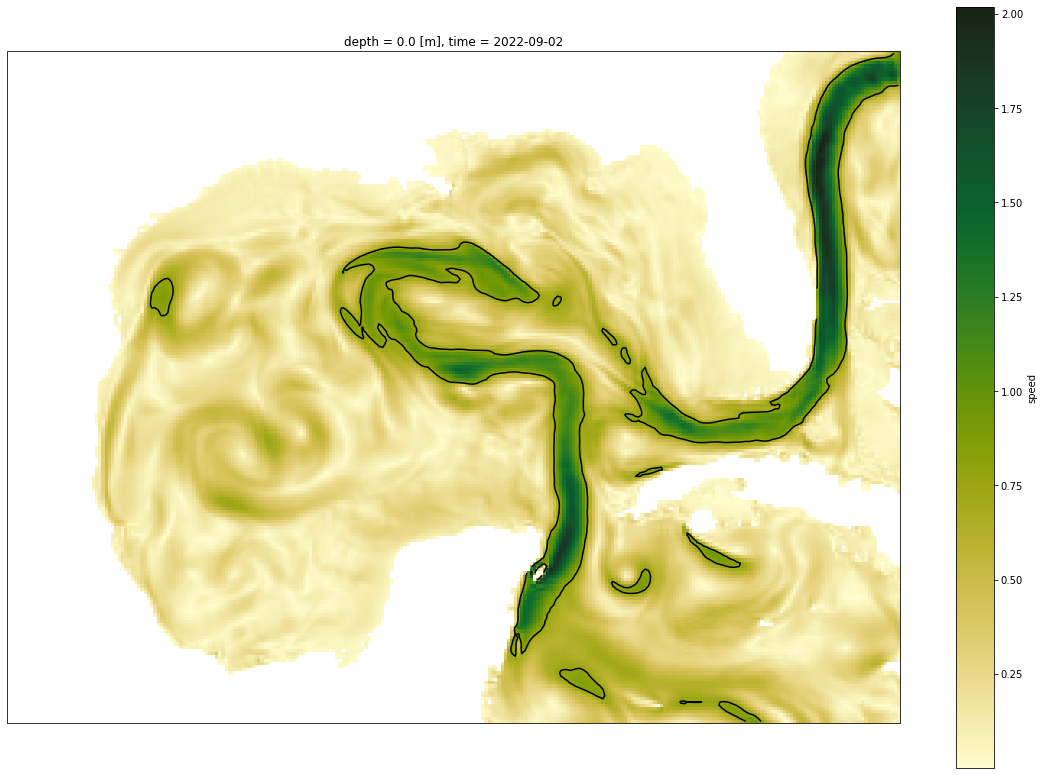

In [43]:
fig, ax = plt.subplots(
    figsize=figsize, #12,9
    subplot_kw=dict(projection=map_proj)
)

tds_sub.speed.plot(ax=ax, x='lon', y='lat', cmap=cmocean.cm.speed, transform=data_proj)
plt.contour(tds_sub['lon'], tds_sub['lat'], tds_sub['speed'], [0.771667], colors='k', transform=data_proj, zorder=100)
# plt.contour(tds_sub['lon'], tds_sub['lat'], tds_sub['speed'], [0.771667], colors='k', transform=data_proj, zorder=100)